Copyright 2020 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Improve model accuracy with data augmentation

This notebook was adapted from the one used for step 7 of the codelab:
-  [**Build a handwritten digit classifier app with TensorFlow Lite**](https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step7_improve_accuracy.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step7_improve_accuracy.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In previous classes, we trained a model that could recognize handwritten digits using the MNIST dataset. We were able to achieve above 98% accuracy on our validation dataset. However, when you deploy the model as real apps, for example in an Android app and test it, you will notice some accuracy issue. Although the app is able to recognize digits that you drew, the accuracy is probably way lower than 98%.

In this notebook, we will explore the cause of the accuracy drop and use data augmentation to improve deployment accuracy (during inference).

## Preparation

Let's start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [3]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.7.0


Import MNIST dataset.

In [4]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

11501568/11490434 [==============================] - 0s 0us/step


Define an utility function so that we can create quickly create multiple models with the same model architecture for comparison.

In [5]:
def create_model():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Confirm that our model can achieve above 98% accuracy on MNIST dataset.

In [6]:
base_model = create_model()
base_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 28s 8ms/step - loss: 0.1387 - accuracy: 0.9577 - val_loss: 0.0492 - val_accuracy: 0.9836
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0546 - accuracy: 0.9829 - val_loss: 0.0473 - val_accuracy: 0.9851
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0404 - accuracy: 0.9876 - val_loss: 0.0367 - val_accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.0357 - val_accuracy: 0.9888
Epoch 5/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0260 - accuracy: 0.9912 - val_loss: 0.0365 - val_accuracy: 0.9890


# Troubleshoot the accuracy drop

Let's see the digit images in MNIST again and guess the cause of the accuracy drop we experienced in deployment.

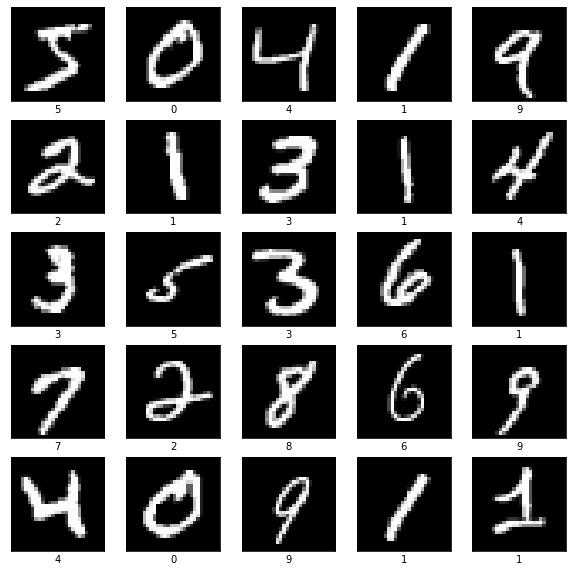

In [7]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

We can see from the 25 images above that the digits are about the same size, and they are in the center of the images. Let's verify if this assumption is true across the MNIST dataset.

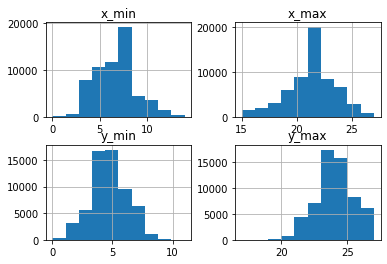

In [8]:
# An utility function that returns where the digit is in the image.
def digit_area(mnist_image):
  # Remove the color axes
  mnist_image = np.squeeze(mnist_image, axis=2)

  # Extract the list of columns that contain at least 1 pixel from the digit
  x_nonzero = np.nonzero(np.amax(mnist_image, 0))
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)

  # Extract the list of rows that contain at least 1 pixel from the digit
  y_nonzero = np.nonzero(np.amax(mnist_image, 1))
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)

  return [x_min, x_max, y_min, y_max]

# Calculate the area containing the digit across MNIST dataset
digit_area_rows = []
for image in train_images:
  digit_area_row = digit_area(image)
  digit_area_rows.append(digit_area_row)
digit_area_df = pd.DataFrame(
  digit_area_rows,
  columns=['x_min', 'x_max', 'y_min', 'y_max']
)
digit_area_df.hist();

Now from the histogram, you can confirm that the digit in MNIST images are fitted nicely in an certain area at the center of the images. 
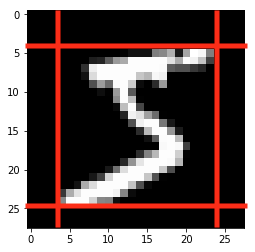



However, when you wrote digits in an Android app, you probably did not pay attention to make sure your digit fit in the virtual area that the digits appear in MNIST dataset. The machine learning model have not seen such data before so it performed poorly, especially when you wrote a digit that was off the center of the drawing pad.

Let's add some data augmentation to the MNIST dataset to verify if our assumption is true. We will distort our MNIST dataset by adding:
* Rotation
* Width and height shift
* Shear
* Zoom

In [9]:
# Define data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.2
)

# Generate augmented data from MNIST dataset
train_generator = datagen.flow(train_images, train_labels)
test_generator = datagen.flow(test_images, test_labels)

Let's see what our digit images look like after augmentation. You can see that we now clearly have much more variation on how the digits are placed in the images.

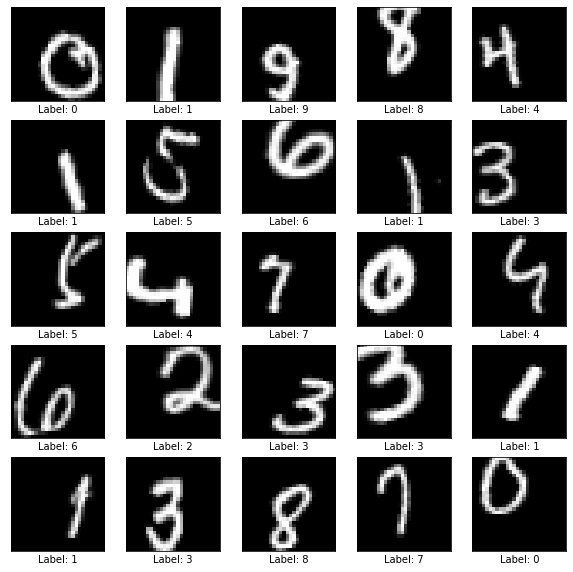

In [10]:
augmented_images, augmented_labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
    plt.xlabel('Label: %d' % augmented_labels[i])
plt.show()

Let's evaluate the digit classifier model that we trained earlier on this augmented test dataset and see if it makes accuracy drop.

In [11]:
base_model.evaluate(test_generator)

313/313 [==============================] - 6s 19ms/step - loss: 5.3083 - accuracy: 0.3269


[5.308299541473389, 0.32690000534057617]

You can see that accuracy significantly dropped to below 40% in augmented test dataset.

# Improve accuracy with data augmentation

Now let's train our model using augmented dataset to make it perform better in deployment.

In [12]:
improved_model = create_model()
improved_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.9884 - accuracy: 0.6833 - val_loss: 0.4918 - val_accuracy: 0.8522
Epoch 2/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.4755 - accuracy: 0.8586 - val_loss: 0.3319 - val_accuracy: 0.9024
Epoch 3/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.3850 - accuracy: 0.8840 - val_loss: 0.2823 - val_accuracy: 0.9149
Epoch 4/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3377 - accuracy: 0.9004 - val_loss: 0.2666 - val_accuracy: 0.9223
Epoch 5/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3106 - accuracy: 0.9075 - val_loss: 0.2507 - val_accuracy: 0.9269


We can see that as the models saw more distorted digit images during training, its accuracy evaluated distorted test digit images were significantly improved to about 90%.

# Convert to TensorFlow Lite

To use the new model, you need to convert the improved model to TensorFlow Lite and redeploy to the Android app.

In [13]:
# Convert Keras model to TF Lite format and quantize.
converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp2dgyq205/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

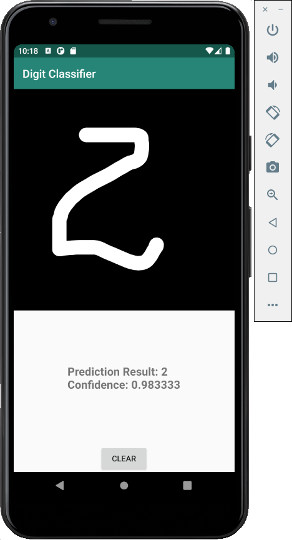

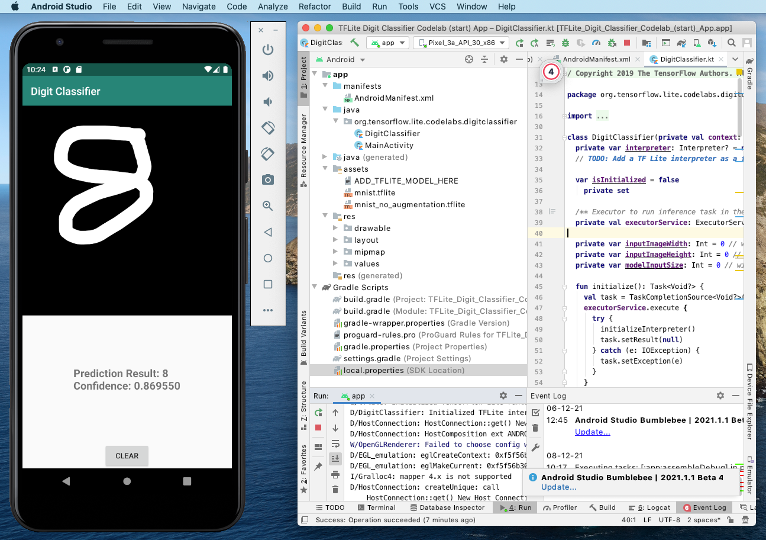